In [92]:
import pandas as pd
import matplotlib.pyplot as plt

excel_file = pd.ExcelFile('jobs.xlsx')
all = []

# for each sheet in the workbook
for sheet in excel_file.sheet_names:
    # read the sheet into a dataframe
    df = pd.read_excel(excel_file, sheet_name=sheet)
    # export the sheet to csv
    df.to_csv('jobs.csv', index=False)
    # convert the dataframe to a list of dictionaries
    json_list = df.to_dict(orient='records')
    
    # add the sheet name to each dictionary
    for item in json_list:
        item['region'] = sheet
        for key, value in item.items():
            if pd.isna(value):
                item[key] = "None"
    all.extend(json_list)


# export the list of dictionaries to a json file
import json 
with open('jobs.json', 'w') as f:
    json.dump(all, f, indent=4)

In [93]:
def clean_jobs(all_jobs, output_path="jobs.json"):
    # Mapping of dirty values -> clean values for sites
    site_fixes = {
        "The  Princess Royal Maternity Unit": "The Princess Royal Maternity Unit",
        "Gartnaval General Hospital": "Gartnavel General Hospital",
        "The Beatson West of Scotland Cancer Centre": "Beatson West of Scotland Cancer Centre",
        "Gilbert Road Medicine Group": "Gilbert Road Medical Group",
        "Drs Cheung, Al-Agilly and Morgan": "Drs Cheung, Al-Agilly & Morgan",
        "Kenmure Practice": "Kenmure Medical Practice",
        "The Aird Medical  Practice - Beauly": "Croyard Road - Beauly",  # or merge with "The Aird Medical Practice"
        "Golden Jubilee University National  Hospital": "Golden Jubilee University National Hospital",
    }

    # Mapping of dirty values -> clean values for specialties
    specialty_fixes = {
        "Cardio-thoracic surgery": "Cardio-thoracic Surgery",
        "Palliative medicine": "Palliative Medicine",
    }

    def clean_value(value, fixes):
        if not value or value == "None" or value.strip() == "":
            return value
        # Collapse multiple spaces
        cleaned = " ".join(value.split())
        # Apply explicit fixes
        return fixes.get(cleaned, fixes.get(value, cleaned))

    for job in all_jobs:
        for i in range(1, 7):
            site_key = f"Placement {i}: Site"
            spec_key = f"Placement {i}: Specialty"

            if site_key in job:
                job[site_key] = clean_value(job[site_key], site_fixes)
            if spec_key in job:
                job[spec_key] = clean_value(job[spec_key], specialty_fixes)

    with open(output_path, "w") as f:
        json.dump(all_jobs, f, indent=2)

    print(f"Cleaned {len(all_jobs)} jobs saved to {output_path}")
    return all_jobs
def get_sites(jobs):
    sites = set()
    for job in jobs:
        for i in range(1, 7):
            site = job.get(f'Placement {i}: Site')
            if site and site != "None" and site.strip() != "":
                sites.add(site)
    return sites
def get_specialties(jobs):
    specialties = set()
    for job in jobs:
        for i in range(1, 7):
            specialty = job.get(f'Placement {i}: Specialty')
            if specialty and specialty != "None" and specialty.strip() != "":
                specialties.add(specialty)
    return specialties

cleaned_jobs = clean_jobs(all)
sites = get_sites(cleaned_jobs)
specialties = get_specialties(cleaned_jobs)

Cleaned 1536 jobs saved to jobs.json


# Overview
Zoom out then zoom in

In [94]:
num_rotations = len(cleaned_jobs)
num_sites = len(sites)
num_specialties = len(specialties)


print(f"Ranking {num_rotations} rotations across {num_sites} sites and {num_specialties} specialties is no small feat.")
print(specialties)

Ranking 1536 rotations across 192 sites and 45 specialties is no small feat.
{'Plastic Surgery', 'Medical Oncology', 'Cardio-thoracic Surgery', 'Chemical Pathology', 'Ophthalmology', 'Renal Medicine', 'General (Internal) Medicine', 'Medical Microbiology', 'Respiratory Medicine', 'Vascular Surgery', 'Paediatric Intensive Care Medicine', 'Trauma and Orthopaedic Surgery', 'Intensive Care Medicine', 'Geriatric Medicine', 'Paediatric Surgery', 'Clinical Oncology', 'Endocrinology and Diabetes Mellitus', 'General Psychiatry', 'Rehabilitation Medicine', 'Cardiology', 'Paediatrics', 'Psychiatry of Learning Disability', 'Anaesthetics', 'General Surgery', 'Old Age Psychiatry', 'Gastroenterology', 'Child and Adolescent Psychiatry', 'Emergency Medicine', 'Neurosurgery', 'Community Sexual and Reproductive Health', 'Histopathology', 'Obstetrics and Gynaecology', 'Haematology', 'Neurology', 'General Practice', 'Urology', 'Academic Foundation Programme', 'Acute Internal Medicine', 'Infectious Diseases'

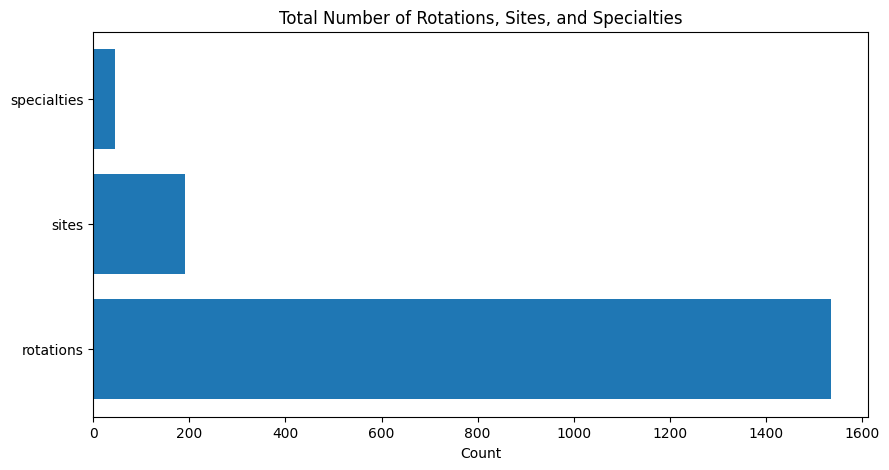

In [95]:
# bar chart of total number of each stat
import matplotlib.pyplot as plt
stats = {
    'rotations': num_rotations,
    'sites': num_sites,
    'specialties': num_specialties
}   
# horizontal bar chart of the stats, very wide, with the stat names on the y axis and the counts on the x axis
plt.figure(figsize=(10, 5))
plt.barh(list(stats.keys()), list(stats.values()))
plt.title('Total Number of Rotations, Sites, and Specialties')
plt.xlabel('Count')

plt.show()

# Regions
Of course, not all regions are built the same...

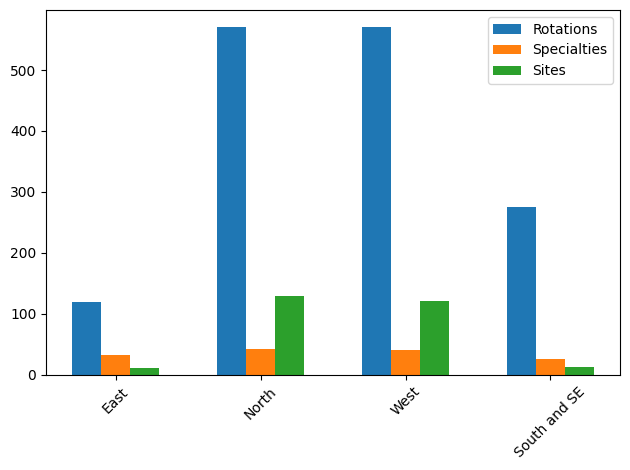

In [96]:
# bar chart of job, specialty, and site counts per region
import matplotlib.pyplot as plt
regions = set(job['region'] for job in all)
rotations_counts= {region: sum(1 for job in all if job['region'] == region) for region in regions}
specialty_counts = {region: len(set(job.get(f'Placement {i}: Specialty') for job in all if job['region'] == region for i in range(1, 7))) for region in regions}
site_counts = {region: len(set(job.get(f'Placement {i}: Site') for job in all if job['region'] == region for i in range(1, 7))) for region in regions}  
x = range(len(regions))
plt.bar(x, rotations_counts.values(), width=0.2, label='Rotations', align='center')
plt.bar([i + 0.2 for i in x], specialty_counts.values(), width=0.2, label='Specialties', align='center')
plt.bar([i + 0.4 for i in x], site_counts.values(), width=0.2, label='Sites', align='center')
plt.xticks([i + 0.2 for i in x], regions, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
print(f"""
West and North have the most roations, with {rotations_counts['West']} each, this makes sense given 
they both have the most sites at {site_counts['West']} and {site_counts['North']} respectively. 

However variety in location does not mean variety in occupation with East having only {(specialty_counts['North'] - specialty_counts['East'])} less specialites
than North, but {site_counts['North'] - site_counts['East']} less sites.

      """)


West and North have the most roations, with 570 each, this makes sense given 
they both have the most sites at 121 and 130 respectively. 

However variety in location does not mean variety in occupation with East having only 10 less specialites
than North, but 119 less sites.

      


# Specialties
What will you actually spend 2 years doing? 

- What percentage of jobs have each specialty - general ideas of frequency over all placements is distinct from freqnecy at the job level i.e. gen med occurs in X percent of all palcements but if it in mre than placement per job it wil loccur in Y percent of all jobs. 
    - General Medicine appears in **84% of all jobs**. General Surgery in 80%. These two are near-unavoidable. 
    - this does mean that there are some big cohorts, particuarly at X hospiral an dY where Z of you start at thesame for tim epalcement a, b and c. 
    - The long tail is fascinating: **Dermatology exists in only 3 jobs**. Psychiatry of Learning Disability: 3. Cardiothoracic Surgery: 9.
    - 21 specialties are available in all 4 regions. But 4 are region-exclusive (Dermatology only in West, Cardiothoracic Surgery only in South & SE, etc.)

(big visualsation of specialty frequency)

- What percentage of jobs havea specialty in fy1 vs fy2.
    - F1 is dominated by Gen Med and Gen Surgery. F2 opens up dramatically: GP appears in 45% of jobs (but _only_ in F2), Emergency Medicine jumps from 54 F1 placements to 360 in F2, Psychiatry barely exists in F1 but is in 24% of F2 jobs.

(side by side viz of fy1 vs fy2 frequency)


### Rquired data
specialty_in_job_freq_per_region

placement_cohort_sizes_per_region

fy1_specialty_in_job_per_region

fy2_specialty_in_job_per_region


In [98]:
def get_specialty_freq(jobs):
    specialty_freq = {}
    for job in jobs:
        specialties_seen_in_job = set()
        for i in range(1, 7):
            specialty = job.get(f'Placement {i}: Specialty')
            if specialty and specialty != "None" and specialty.strip() != "":
                if specialty in specialties_seen_in_job:
                    continue
                specialties_seen_in_job.add(specialty)
                if specialty not in specialty_freq:
                    specialty_freq[specialty] = 0
                specialty_freq[specialty] += 1
    return specialty_freq

def get_specialty_in_job_freq_per_region(jobs):
    specialty_freq_per_region = {}
    for job in jobs:
        specialties_seen_in_job = set()
        region = job['region']
        if region not in specialty_freq_per_region:
            specialty_freq_per_region[region] = {}
        for i in range(1,7):
            specialty = job.get(f'Placement {i}: Specialty')
            if specialty and specialty != "None" and specialty.strip() != "":
                if specialty in specialties_seen_in_job:
                    continue
                specialties_seen_in_job.add(specialty)
                if specialty not in specialty_freq_per_region[region]:
                    specialty_freq_per_region[region][specialty] = 0
                specialty_freq_per_region[region][specialty] += 1
    return specialty_freq_per_region

def get_placement_cohort_size_per_region(jobs):
    cohort_size_per_region = {}
    for job in jobs:
        region = job['region']
        if region not in cohort_size_per_region:
            cohort_size_per_region[region] = {}
        for i in range(1, 7):
            site = job.get(f'Placement {i}: Site')
            specialty = job.get(f'Placement {i}: Specialty')
            if site and site != "None" and site.strip() != "" and specialty and specialty != "None" and specialty.strip() != "":
                if site not in cohort_size_per_region[region]:
                    cohort_size_per_region[region][site] = {}
                if specialty not in cohort_size_per_region[region][site]:
                    cohort_size_per_region[region][site][specialty] = {}
                if i not in cohort_size_per_region[region][site][specialty]:
                    cohort_size_per_region[region][site][specialty][i] = 0 
                cohort_size_per_region[region][site][specialty][i] += 1
    return cohort_size_per_region

def get_fyx_specialty_in_job_freq_per_region(jobs, x: 1 | 2):
    placement_numbers = range(1, 4) if x == 1 else range(4, 7)
    specialty_freq_per_region = {}
    for job in jobs:
        specialties_seen_in_job = set()
        region = job['region']
        if region not in specialty_freq_per_region:
            specialty_freq_per_region[region] = {}
        for i in placement_numbers:
            specialty = job.get(f'Placement {i}: Specialty')
            if specialty and specialty != "None" and specialty.strip() != "":
                if specialty in specialties_seen_in_job:
                    continue
                specialties_seen_in_job.add(specialty)
                if specialty not in specialty_freq_per_region[region]:
                    specialty_freq_per_region[region][specialty] = 0
                specialty_freq_per_region[region][specialty] += 1
    return specialty_freq_per_region

def _sorted_freq(freq_dict):
    """Sort a {name: count} dict descending by count."""
    return sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

def _print_top_bottom(sorted_items, n=3, total=None):
    """Print top and bottom n from a sorted list of (name, count) tuples."""
    fmt = lambda name, count: (
        f"      {name}: {count} ({(count/total)*100:.1f}%)" if total
        else f"      {name}: {count}"
    )
    print(f"    Top {n}:")
    for name, count in sorted_items[:n]:
        print(fmt(name, count))
    print(f"    Bottom {n}:")
    for name, count in sorted_items[-n:]:
        print(fmt(name, count))

def print_overall_freq(specialty_freq, num_jobs, top=5, bottom=3):
    """Print overall specialty frequency as % of jobs."""
    print("=" * 60)
    print("OVERALL SPECIALTY FREQUENCY (% of jobs)")
    print("=" * 60)
    sorted_specs = _sorted_freq(specialty_freq)
    print(f"  Top {top}:")
    for spec, freq in sorted_specs[:top]:
        print(f"    {spec}: {(freq/num_jobs)*100:.1f}%")
    print(f"  Bottom {bottom}:")
    for spec, freq in sorted_specs[-bottom:]:
        print(f"    {spec}: {(freq/num_jobs)*100:.1f}%")

def print_fy_freq_by_region(fy_freq, jobs, fy_label, regions, n=3):
    """Print top/bottom n specialties per region for FY1 or FY2."""
    print("\n" + "=" * 60)
    print(f"{fy_label} SPECIALTY FREQUENCY BY REGION")
    print("=" * 60)
    for region in regions:
        if region not in fy_freq:
            continue
        region_jobs = sum(1 for j in jobs if j['region'] == region)
        sorted_specs = _sorted_freq(fy_freq[region])
        print(f"\n  {region} ({region_jobs} jobs):")
        _print_top_bottom(sorted_specs, n=n, total=region_jobs)

def print_cohort_sizes_by_region(cohort_data, regions, n=3):
    """Print top/bottom n cohorts (site+specialty+placement) per region."""
    print("\n" + "=" * 60)
    print("LARGEST COHORTS BY REGION (site + specialty + placement #)")
    print("=" * 60)
    for region in regions:
        if region not in cohort_data:
            continue
        cohorts = []
        for site, specs in cohort_data[region].items():
            for spec, placements in specs.items():
                for p_num, count in placements.items():
                    cohorts.append((site, spec, p_num, count))
        cohorts.sort(key=lambda x: x[3], reverse=True)
        print(f"\n  {region}:")
        print(f"    Top {n} largest cohorts:")
        for site, spec, p_num, count in cohorts[:n]:
            print(f"      {site} — {spec} (P{p_num}): {count} people")
        print(f"    Smallest {n} cohorts:")
        for site, spec, p_num, count in cohorts[-n:]:
            print(f"      {site} — {spec} (P{p_num}): {count} people")

def print_all_summaries(jobs, regions=None, n=3):
    """Compute all data and print full summary."""
    if regions is None:
        regions = ["North", "East", "West", "South and SE"]

    specialty_freq = get_specialty_freq(jobs)
    cohort_data = get_placement_cohort_size_per_region(jobs)
    fy1_freq = get_fyx_specialty_in_job_freq_per_region(jobs, 1)
    fy2_freq = get_fyx_specialty_in_job_freq_per_region(jobs, 2)

    print_overall_freq(specialty_freq, len(jobs))
    print_fy_freq_by_region(fy1_freq, jobs, "FY1", regions, n=n)
    print_fy_freq_by_region(fy2_freq, jobs, "FY2", regions, n=n)
    print_cohort_sizes_by_region(cohort_data, regions, n=n)

    return specialty_freq, fy1_freq, fy2_freq, cohort_data

# --- Run ---
specialty_freq, fyx1_specialty_freq_per_region, fyx2_specialty_freq_per_region, cohort_size_per_region = print_all_summaries(cleaned_jobs)
specialty_freq_per_region = get_specialty_in_job_freq_per_region(cleaned_jobs)

OVERALL SPECIALTY FREQUENCY (% of jobs)
  Top 5:
    General (Internal) Medicine: 83.9%
    General Surgery: 79.8%
    General Practice: 45.4%
    Geriatric Medicine: 31.2%
    Trauma and Orthopaedic Surgery: 28.7%
  Bottom 3:
    Paediatric Intensive Care Medicine: 0.4%
    Psychiatry of Learning Disability: 0.2%
    Dermatology: 0.2%

FY1 SPECIALTY FREQUENCY BY REGION

  North (570 jobs):
    Top 3:
      General Surgery: 450 (78.9%)
      General (Internal) Medicine: 415 (72.8%)
      Acute Internal Medicine: 174 (30.5%)
    Bottom 3:
      Neurology: 4 (0.7%)
      General Psychiatry: 3 (0.5%)
      Paediatric Intensive Care Medicine: 3 (0.5%)

  East (120 jobs):
    Top 3:
      General Surgery: 58 (48.3%)
      General (Internal) Medicine: 55 (45.8%)
      Trauma and Orthopaedic Surgery: 48 (40.0%)
    Bottom 3:
      General Psychiatry: 3 (2.5%)
      Acute Internal Medicine: 3 (2.5%)
      Paediatrics: 3 (2.5%)

  West (570 jobs):
    Top 3:
      General (Internal) Medicine: 5

In [101]:
import math
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter

TIERS = [
    (0.5, "Legendary", "#f59e0b"),
    (1.5, "Epic", "#a855f7"),
    (4.0, "Rare", "#3b82f6"),
    (10.0, "Uncommon", "#22c55e"),
    (float("inf"), "Common", "#64748b"),
]

def get_tier(pct):
    for threshold, name, color in TIERS:
        if pct < threshold:
            return name, color


def _tangent_positions(x1, y1, r1, x2, y2, r2, r):
    """Find positions for a circle of radius r tangent to two existing circles."""
    d = math.hypot(x2 - x1, y2 - y1)
    a, b = r1 + r, r2 + r
    if d < 1e-10 or d > a + b:
        return []
    cos_a = (a**2 + d**2 - b**2) / (2 * a * d)
    if abs(cos_a) > 1:
        return []
    angle = math.atan2(y2 - y1, x2 - x1)
    arc = math.acos(cos_a)
    return [
        (x1 + a * math.cos(angle + s * arc), y1 + a * math.sin(angle + s * arc))
        for s in (1, -1)
    ]


def pack_circles(radii):
    """Circle-pack by placing each new circle tangent to the closest pair."""
    if not radii:
        return []
    order = sorted(range(len(radii)), key=lambda i: -radii[i])
    positions = [None] * len(radii)
    placed = []

    for idx in order:
        r = radii[idx]
        if not placed:
            positions[idx] = (0.0, 0.0, r)
            placed.append((0.0, 0.0, r))
            continue
        if len(placed) == 1:
            px, py, pr = placed[0]
            pos = (px + pr + r, py, r)
            positions[idx] = pos
            placed.append(pos)
            continue

        best_pos, best_dist = None, float("inf")
        for i in range(len(placed)):
            for j in range(i + 1, len(placed)):
                x1, y1, r1 = placed[i]
                x2, y2, r2 = placed[j]
                for cx, cy in _tangent_positions(x1, y1, r1, x2, y2, r2, r):
                    dist = math.hypot(cx, cy)
                    if dist >= best_dist:
                        continue
                    has_overlap = False
                    for px, py, pr in placed:
                        if math.hypot(cx - px, cy - py) < pr + r - 0.5:
                            has_overlap = True
                            break
                    if not has_overlap:
                        best_pos, best_dist = (cx, cy), dist

        positions[idx] = (best_pos[0], best_pos[1], r)
        placed.append(positions[idx])

    return positions


def count_specialties(jobs, slots):
    """Count specialty occurrences across the given placement slots."""
    counts = Counter()
    for job in jobs:
        for i in slots:
            spec = job.get(f"Placement {i}: Specialty", "")
            if spec and spec != "None" and spec.strip():
                counts[spec] += 1
    return counts


def plot_bubble_chart(region="All Regions", placement="All Placements"):
    """Draw a packed bubble chart of specialty frequency, coloured by rarity tier."""
    filtered = cleaned_jobs if region == "All Regions" else [j for j in cleaned_jobs if j["region"] == region]
    slots = range(1, 7) if placement == "All Placements" else [int(placement.split()[-1])]
    counts = count_specialties(filtered, slots)

    if not counts:
        print("No data for this filter combination.")
        return

    total = sum(counts.values())
    items = sorted(counts.items(), key=lambda x: -x[1])
    max_count = items[0][1]
    MIN_R, MAX_R = 3, 45
    radii = [MIN_R + (MAX_R - MIN_R) * math.sqrt(c / max_count) for _, c in items]
    circles = pack_circles(radii)

    # --- Draw ---
    fig, ax = plt.subplots(figsize=(8, 14), facecolor="#0c0f14")
    ax.set_facecolor("#0c0f14")
    ax.set_aspect("equal")
    ax.axis("off")

    subtitle = " · ".join(
        p for p in [region if region != "All Regions" else None,
                    placement if placement != "All Placements" else None] if p
    ) or "All Regions · All Placements"
    ax.set_title(
        f"Specialty Rarity — {subtitle}\n{len(counts)} specialties across {total:,} placement slots",
        fontsize=16, color="#e8eaed", pad=20, fontweight=500, fontstyle="italic",
    )

    for i, (name, count) in enumerate(items):
        cx, cy, r = circles[i]
        pct = (count / total) * 100
        _, color = get_tier(pct)
        ax.add_patch(plt.Circle(
            (cx, cy), r,
            facecolor=to_rgba(color, 0.15),
            edgecolor=to_rgba(color, 0.6),
            linewidth=1.5,
        ))
        if r > 8:
            label = name if len(name) < 20 else name[:18] + "…"
            fs = max(5.5, min(10, r * 0.38))
            ax.text(cx, cy + 1, label, ha="center", va="center", fontsize=fs, color=color, fontweight=600)
            ax.text(cx, cy - r * 0.3, f"{count}  ({pct:.1f}%)", ha="center", va="center",
                    fontsize=max(5, fs - 1.5), color=to_rgba(color, 0.6))
        elif r > 5:
            ax.text(cx, cy, name[:12], ha="center", va="center",
                    fontsize=max(4.5, r * 0.4), color=color, fontweight=500)

    # Legend
    for idx, (threshold, tier_name, color) in enumerate(TIERS):
        lx, ly = -80, -70 - idx * 5
        labels = ["<0.5%", "0.5–1.5%", "1.5–4%", "4–10%", "≥10%"]
        ax.add_patch(plt.Circle((lx, ly), 1.5, facecolor=to_rgba(color, 0.3), edgecolor=to_rgba(color, 0.7), linewidth=1))
        ax.text(lx + 3.5, ly, f"{tier_name} ({labels[idx]})", fontsize=7, color=to_rgba(color, 0.9), va="center")

    ax.autoscale()
    ax.margins(0.05)
    plt.tight_layout()
    plt.show()


# --- Interactive widgets ---
region_options = ["All Regions"] + sorted(set(j["region"] for j in cleaned_jobs))
placement_options = ["All Placements"] + [f"Placement {i}" for i in range(1, 7)]

region_dd = widgets.Dropdown(options=region_options, value="All Regions", description="Region:", style={"description_width": "60px"})
placement_dd = widgets.Dropdown(options=placement_options, value="All Placements", description="Placement:", style={"description_width": "70px"})
output = widgets.Output()

def on_change(_):
    with output:
        clear_output(wait=True)
        plot_bubble_chart(region_dd.value, placement_dd.value)

region_dd.observe(on_change, names="value")
placement_dd.observe(on_change, names="value")

display(widgets.HBox([region_dd, placement_dd]))
display(output)
with output:
    plot_bubble_chart()

Output()

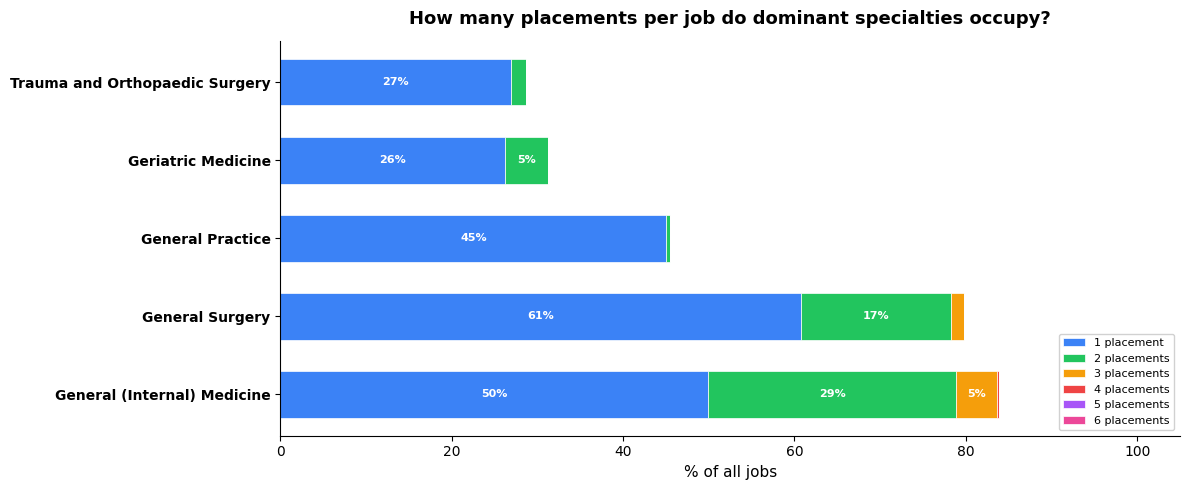


General (Internal) Medicine:
  Appears in 1288/1536 jobs (83.9%)
  Multiple placements in 521/1536 jobs (33.9%)
    1 placement: 767 jobs
    2 placements: 445 jobs
    3 placements: 72 jobs
    4 placements: 4 jobs

General Surgery:
  Appears in 1225/1536 jobs (79.8%)
  Multiple placements in 291/1536 jobs (18.9%)
    1 placement: 934 jobs
    2 placements: 268 jobs
    3 placements: 23 jobs


In [113]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def placement_count_distribution(jobs, specialty, max_placements=6):
    """Count how many jobs have exactly 0, 1, 2, ... N placements of a given specialty."""
    dist = Counter()
    for job in jobs:
        n = sum(
            1 for i in range(1, 7)
            if job.get(f"Placement {i}: Specialty") == specialty
        )
        dist[n] += 1
    return {k: dist.get(k, 0) for k in range(max_placements + 1)}

# Top specialties by number of jobs they appear in
top_specialties = ["General (Internal) Medicine", "General Surgery", "General Practice",
                   "Geriatric Medicine", "Trauma and Orthopaedic Surgery"]

distributions = {spec: placement_count_distribution(cleaned_jobs, spec) for spec in top_specialties}

# --- Stacked horizontal bar chart (1–6 placements only) ---
fig, ax = plt.subplots(figsize=(12, 5))

max_n = max(max(d.keys()) for d in distributions.values())
colors = ["#3b82f6", "#22c55e", "#f59e0b", "#ef4444", "#a855f7", "#ec4899"]
labels = [f"{n} placement{'s' if n != 1 else ''}" for n in range(1, max_n + 1)]

y_pos = np.arange(len(top_specialties))
left = np.zeros(len(top_specialties))
total_jobs = len(cleaned_jobs)

for ni, n in enumerate(range(1, max_n + 1)):
    widths = [distributions[spec].get(n, 0) for spec in top_specialties]
    pcts = [w / total_jobs * 100 for w in widths]
    bars = ax.barh(y_pos, pcts, left=left, height=0.6,
                   color=colors[ni % len(colors)], label=labels[ni], edgecolor="white", linewidth=0.5)
    for bar, pct in zip(bars, pcts):
        if pct > 4:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f"{pct:.0f}%", ha="center", va="center", fontsize=8, fontweight=600, color="white")
    left += pcts

ax.set_yticks(y_pos)
ax.set_yticklabels(top_specialties, fontsize=10, fontweight=600)
ax.set_xlabel("% of all jobs", fontsize=11)
ax.set_title("How many placements per job do dominant specialties occupy?", fontsize=13, fontweight=600, pad=12)
ax.legend(loc="lower right", fontsize=8, framealpha=0.9)
ax.set_xlim(0, 105)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

# Print summary for the big two
for spec in top_specialties[:2]:
    dist = distributions[spec]
    multi = sum(v for k, v in dist.items() if k > 1)
    any_count = sum(v for k, v in dist.items() if k >= 1)
    print(f"\n{spec}:")
    print(f"  Appears in {any_count}/{total_jobs} jobs ({any_count/total_jobs*100:.1f}%)")
    print(f"  Multiple placements in {multi}/{total_jobs} jobs ({multi/total_jobs*100:.1f}%)")
    for n in sorted(dist.keys()):
        if dist[n] > 0 and n > 0:
            print(f"    {n} placement{'s' if n != 1 else ''}: {dist[n]} jobs")